In [1335]:
%reset -f
%load_ext autoreload
%autoreload 2

import Odin as backend

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1336]:
# validation test for scalar diffusion with a constant source term
# this validation test follows "H K Versteeg and W Malalasekera, An Introduction to Computational Fluid Dynamics
# THE FINITE VOLUME METHOD, Second Edition, 2007" examples 4.1,4.2

# the temperature along the x-axis should develop as:

def yFunc(x):
    return ((T_r-T_l)/LenX + S/(2*k)*(LenX-x))*x + T_l

# geometric parameters
LenX = 0.02
LenY = 0.004

# thermal conductivity [ W / (m K) ]
k = 0.5

# heat source [ W / m^3 ]
S = 0

# const temperature at left/right boundaries [K]
T_l = 100
T_r = 500

In [1337]:
geom = backend.createGeometry( 'rectangle', [LenX, LenY] )
mesh = backend.createMesh( geom, res=250 )
mesh.getStats()

# example: incompressible flow but with temp-dep density, i.e. BoussinesqFlow
# mulitphase stokes flow
myFlowModels = {
    #'flowField'     :   backend.FlowModels.IncompressibleFlow(),
    #'soluteTransport':  backend.FlowModels.ScalarConvectionDiffusion(),
    'temperature'   :   backend.FlowModels.ScalarConvectionDiffusion(scalarFieldName='T', velocityFieldName='U', diffusionCoefficientName='k', sourceFieldName='R')
    }

myFlowModels['temperature'].showContinuumProperties()

sim1 = backend.Simulation(myFlowModels, mesh, geom )
#print(type(sim1._variableFields['U']).__name__) # i can use this to remove the member variable _type

5
ScalarConvectionDiffusion:
	 {'diffusionCoefficient': 1, 'sourceFieldName': 'R', 'scalarFieldName': 'T', 'velocityFieldName': 'U'}


In [ ]:
# changing boundary conditions
myFields = sim1.getFields()
T = myFields['T']
T.setBoundaryCondition('top', 'zeroGradient')
T.setBoundaryCondition('bottom', 'zeroGradient')
T.setBoundaryCondition('left', T_l)
T.setBoundaryCondition('right', T_r)

# setting conductivity and heat source:
myFields['k'] = k
R = myFields['R']
R._raw[:,:] = S

sim1.showfields()

sim1.compile()

T.solve()

variable fields :
	 T 	 variableCellField 	 {'left': 100, 'right': 500, 'top': 'zeroGradient', 'bottom': 'zeroGradient'}
parameter fields :
	 U 	 parameterFaceField
	 R 	 parameterCellField
	 k 	 scalar




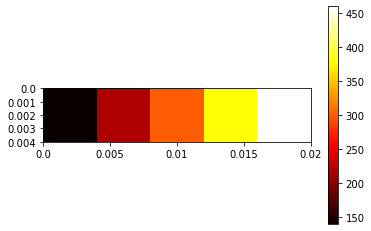

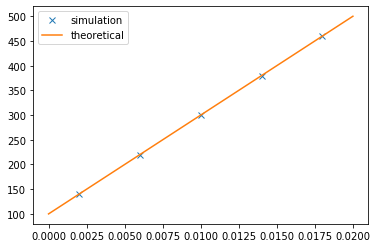

[140. 220. 300. 380. 460.]


In [1339]:
# post-processing:
import numpy as np
import matplotlib.pyplot as plt

sim1.display(T)

nbcellsX = sim1._mesh._cells_x
cellSpacing = sim1._mesh._uniformSpacing
L = geom._lenX

xSim = np.linspace(0+0.5*cellSpacing,0.02-0.5*cellSpacing,nbcellsX)
ySim = T._raw[0,:]

xTheo = np.linspace(0,LenX, 100)
yTheor = np.array([yFunc(x) for x in xTheo])

ax = plt.gca()
ax.plot(xSim, ySim, 'x', label='simulation')
ax.plot(xTheo, yTheor, label='theoretical')

plt.legend()
plt.show()

print(ySim)